# Message Passing

In this notebook, we'll introduce the concept of Graph Convolution Neural Networks, specifically Message Passing Neural Networks.

In [1]:
smiles = []
with open('../data/01_raw/moses/dataset_v1.csv', 'r') as f:
    _ = f.readline()
    smiles = [f.readline().split(',')[0] for _ in range(120)]
    f.close()

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
DrawingOptions.bondLineWidth=1.8

import os,sys,inspect
sys.path.insert(0,'/home/icarus/T-CVAE-MolGen/src') 

lg = RDLogger.logger()

lg.setLevel(RDLogger.CRITICAL)

RDKit WARNING: [01:16:19] Enabling RDKit 2019.09.1 jupyter extensions


## Feature Extraction

In [2]:
from structures.moltree import MolTree
from structures.mol_features import N_ATOM_FEATS, N_BOND_FEATS
mt = MolTree(smiles[0])

import networkx as nx
import matplotlib.pyplot as plt
plt.subplot(121)
nx.draw(mt.to_networkx(), with_labels=True)
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
graph, atom_features, bond_features = mt.encode(recssemble=True)
print(atom_features.shape)
print(bond_features.shape)

del atom_features
del bond_features

torch.Size([19, 97])
torch.Size([40, 13])


In [4]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph, mean_nodes

## Loopy Belief Propagation



In [5]:
mpn_loopy_bp_msg = fn.copy_src(src='msg', out='msg')
mpn_loopy_bp_reduce = fn.sum(msg='msg', out='accum_msg')

class LoopyBeliefProp_Update(nn.Module):
    def __init__(self, hidden_size):
        super(LoopyBeliefProp_Update, self).__init__()
        self.hidden_size = hidden_size
        
        self.W_h = nn.Linear(  # y = xA^T + b
            in_features=hidden_size,
            out_features=hidden_size,
            bias=False
        )
    
    def forward(self, nodes):
        msg_input = nodes.data['msg_input']
        msg_delta = self.W_h(nodes.data['accum_msg'])
        msg = F.relu(msg_input + msg_delta)
        return {'msg': msg}

## Reduce

In [6]:
mpn_gather_msg = fn.copy_edge(edge='msg', out='msg')
mpn_gather_reduce = fn.sum(msg='msg', out='m')

class MPN_Gather_Update(nn.Module):
    def __init__(self, hidden_size):
        super(MPN_Gather_Update, self).__init__()
        self.hidden_size = hidden_size
        
        self.W_o = nn.Linear(N_ATOM_FEATS + hidden_size, hidden_size)
        
    def forward(self, nodes):
        m = nodes.data['m']
        return {
            'h': F.relu(
                self.W_o(torch.cat([nodes.data['x'], m], 1))
            )
        }

## MPN

In [7]:
import argparse

class GraphConvNet(nn.Module):
    """GraphConvNet [summary].

    Parameters
    ----------
    nn : [type]
        [description]
    """
    def __init__(self,
                 args):#): argparse.Namespace):
        super(GraphConvNet, self).__init__()
        self.args = args
        self.depth = args.depth
        self.hidden_size = args.hidden_size
        self.n_samples_total = 0
        self.n_nodes_total = 0
        self.n_edges_total = 0
        self.n_passes = 0

        """Message Passing Network."""
        self.W_msg_i = nn.Linear(N_ATOM_FEATS +
                                 N_BOND_FEATS,
                                 args.hidden_size,
                                 bias=False)
        
        self.apply_mod = LoopyBeliefProp_Update(args.hidden_size)
        self.gather_updater = MPN_Gather_Update(args.hidden_size)

        
        """Dropout."""
        #self.dropout = nn.Dropout(args.dropout)

    """ [summary]

    Returns
    -------
    [type]
        [description]
    """
    def forward(self, 
                mol_graph: MolTree
                ):
        
        mol_line_graph = mol_graph.line_graph(backtracking=False,
                                              shared=True)
        
        n_edges = mol_graph.number_of_edges()
        n_nodes = mol_graph.number_of_nodes()
        n_samples = mol_graph.batch_size
        
        """Run."""
        mol_graph.apply_edges(
            func=lambda edges: {'src_x': edges.src['x']},
        )

        e_repr = mol_line_graph.ndata
        bond_features = e_repr['x']
        source_features = e_repr['src_x']

        features = torch.cat([source_features, bond_features], 1)
        msg_input = self.W_msg_i(features)
        mol_line_graph.ndata.update({
            'msg_input': msg_input,
            'msg': F.relu(msg_input),
            'accum_msg': torch.zeros_like(msg_input),
        })
        mol_graph.ndata.update({
            'm': bond_features.new(n_nodes, self.hidden_size).zero_(),
            'h': bond_features.new(n_nodes, self.hidden_size).zero_(),
        })

        for i in range(self.depth - 1):
            mol_line_graph.update_all(
                mpn_loopy_bp_msg,
                mpn_loopy_bp_reduce,
                self.apply_mod,
            )

        mol_graph.update_all(
            mpn_gather_msg,
            mpn_gather_reduce,
            self.gather_updater,
        )

        g_repr = mean_nodes(mol_graph, 'h')
        
        self.n_samples_total += n_samples
        self.n_nodes_total += n_nodes
        self.n_edges_total += n_edges
        self.n_passes += 1
        
        return g_repr

In [8]:
from torch.utils.data import Dataset
from structures import Vocab
from typing import List, Tuple
import torch as torch

class JTNNCollator(object):
    def __init__(self, vocab: Vocab, training: bool, intermediates=False):
        self.vocab = vocab
        self.training = training
        self.intermediates = intermediates

    @staticmethod
    def _batch_and_set(graphs: List,
                       atom_x: torch.Tensor,
                       bond_x: torch.Tensor,
                       flatten: bool) -> dgl.BatchedDGLGraph:
        if flatten:
            graphs = [g for f in graphs for g in f]
            
        graph_batch = dgl.batch(graphs)
        graph_batch.ndata['x'] = atom_x
        graph_batch.edata.update({
            'x': bond_x,
            'src_x': atom_x.new(bond_x.shape[0], atom_x.shape[1]).zero_(),
        })
        return graph_batch

    def __call__(self, examples):
        # get list of trees
        mol_trees = _unpack_field(examples, 'mol_tree')
        smiles = _unpack_field(examples, 'smiles')
        wid = _unpack_field(examples, 'wid')
        for _wid, mol_tree in zip(wid, mol_trees):
            mol_tree.ndata['wid'] = torch.LongTensor(_wid)

        # TODO: either support pickling or get around ctypes pointers using scipy
        # batch molecule graphs
        mol_graphs = _unpack_field(examples, 'mol_graph')
        atom_x = torch.cat(_unpack_field(examples, 'atom_x_enc'))
        bond_x = torch.cat(_unpack_field(examples, 'bond_x_enc'))
        mol_graph_batch = self._batch_and_set(mol_graphs, atom_x, bond_x, False)

        result = {
                'mol_trees': mol_trees,
                'mol_graph_batch': mol_graph_batch,
                }

        if not self.training:
            return result

        # batch candidate graphs
        cand_graphs = _unpack_field(examples, 'cand_graphs')
        cand_batch_idx = []
        atom_x = torch.cat(_unpack_field(examples, 'atom_x_dec'))
        bond_x = torch.cat(_unpack_field(examples, 'bond_x_dec'))
        tree_mess_src_e = _unpack_field(examples, 'tree_mess_src_e')
        tree_mess_tgt_e = _unpack_field(examples, 'tree_mess_tgt_e')
        tree_mess_tgt_n = _unpack_field(examples, 'tree_mess_tgt_n')

        n_graph_nodes = 0
        n_tree_nodes = 0
        for i in range(len(cand_graphs)):
            tree_mess_tgt_e[i] += n_graph_nodes
            tree_mess_src_e[i] += n_tree_nodes
            tree_mess_tgt_n[i] += n_graph_nodes
            n_graph_nodes += sum(g.number_of_nodes() for g in cand_graphs[i])
            n_tree_nodes += mol_trees[i].number_of_nodes()
            cand_batch_idx.extend([i] * len(cand_graphs[i]))
        tree_mess_tgt_e = torch.cat(tree_mess_tgt_e)
        tree_mess_src_e = torch.cat(tree_mess_src_e)
        tree_mess_tgt_n = torch.cat(tree_mess_tgt_n)

        cand_graph_batch = self._batch_and_set(cand_graphs, atom_x, bond_x, True)

        # batch stereoisomers
        stereo_cand_graphs = _unpack_field(examples, 'stereo_cand_graphs')
        atom_x = torch.cat(_unpack_field(examples, 'stereo_atom_x_enc'))
        bond_x = torch.cat(_unpack_field(examples, 'stereo_bond_x_enc'))
        stereo_cand_batch_idx = []
        for i in range(len(stereo_cand_graphs)):
            stereo_cand_batch_idx.extend([i] * len(stereo_cand_graphs[i]))

        if len(stereo_cand_batch_idx) > 0:
            stereo_cand_labels = [
                    (label, length)
                    for ex in _unpack_field(examples, 'stereo_cand_label')
                    for label, length in ex
                    ]
            stereo_cand_labels, stereo_cand_lengths = zip(*stereo_cand_labels)
            stereo_cand_graph_batch = self._batch_and_set(
                    stereo_cand_graphs, atom_x, bond_x, True)
        else:
            stereo_cand_labels = []
            stereo_cand_lengths = []
            stereo_cand_graph_batch = None
            stereo_cand_batch_idx = []

        result.update({
            'cand_graph_batch': cand_graph_batch,
            'cand_batch_idx': cand_batch_idx,
            'tree_mess_tgt_e': tree_mess_tgt_e,
            'tree_mess_src_e': tree_mess_src_e,
            'tree_mess_tgt_n': tree_mess_tgt_n,
            'smiles': smiles,
            'stereo_cand_graph_batch': stereo_cand_graph_batch,
            'stereo_cand_batch_idx': stereo_cand_batch_idx,
            'stereo_cand_labels': stereo_cand_labels,
            'stereo_cand_lengths': stereo_cand_lengths,
            })
        
        if self.intermediates:
            result.update({
                'img_grid': _unpack_field(examples, 'img_grid'),
                'smiles_img': _unpack_field(examples, 'smiles_img')
            })

        return result

In [9]:
from structures.mol_features import get_atom_features, get_bond_features
import torch as torch

def mol2dgl_dec(cand_batch: List[Tuple[Chem.rdchem.Mol, MolTree, int]]):
    cand_graphs = []
    tree_mess_source_edges = [] # map these edges from trees to...
    tree_mess_target_edges = [] # these edges on candidate graphs
    tree_mess_target_nodes = []
    n_nodes = 0
    n_edges = 0
    atom_x = []
    bond_x = []

    for mol, mol_tree, ctr_node_id in cand_batch:
        n_atoms = mol.GetNumAtoms()
        n_bonds = mol.GetNumBonds()

        ctr_node = mol_tree.nodes_dict[ctr_node_id]
        ctr_bid = ctr_node['idx']
        g = DGLGraph()

        for i, atom in enumerate(mol.GetAtoms()):
            assert i == atom.GetIdx()
            atom_x.append(get_atom_features(atom))
        g.add_nodes(n_atoms)

        bond_src = []
        bond_dst = []
        for i, bond in enumerate(mol.GetBonds()):
            a1 = bond.GetBeginAtom()
            a2 = bond.GetEndAtom()
            begin_idx = a1.GetIdx()
            end_idx = a2.GetIdx()
            features = get_bond_features(bond)

            bond_src.append(begin_idx)
            bond_dst.append(end_idx)
            bond_x.append(features)
            bond_src.append(end_idx)
            bond_dst.append(begin_idx)
            bond_x.append(features)

            x_nid, y_nid = a1.GetAtomMapNum(), a2.GetAtomMapNum()
            # Tree node ID in the batch
            x_bid = mol_tree.nodes_dict[x_nid - 1]['idx'] if x_nid > 0 else -1
            y_bid = mol_tree.nodes_dict[y_nid - 1]['idx'] if y_nid > 0 else -1
            if x_bid >= 0 and y_bid >= 0 and x_bid != y_bid:
                if mol_tree.has_edge_between(x_bid, y_bid):
                    tree_mess_target_edges.append((begin_idx + n_nodes, end_idx + n_nodes))
                    tree_mess_source_edges.append((x_bid, y_bid))
                    tree_mess_target_nodes.append(end_idx + n_nodes)
                if mol_tree.has_edge_between(y_bid, x_bid):
                    tree_mess_target_edges.append((end_idx + n_nodes, begin_idx + n_nodes))
                    tree_mess_source_edges.append((y_bid, x_bid))
                    tree_mess_target_nodes.append(begin_idx + n_nodes)

        n_nodes += n_atoms
        g.add_edges(bond_src, bond_dst)
        cand_graphs.append(g)

    return cand_graphs, torch.stack(atom_x), \
            torch.stack(bond_x) if len(bond_x) > 0 else torch.zeros(0), \
            torch.LongTensor(tree_mess_source_edges), \
            torch.LongTensor(tree_mess_target_edges), \
            torch.LongTensor(tree_mess_target_nodes)

In [10]:
from dgl.data.utils import download, extract_archive, get_download_dir

_url = 'https://s3-ap-southeast-1.amazonaws.com/dgl-data-cn/dataset/jtnn.zip'

from structures.vocab import Vocab
from utils.chemutils import get_mol
from structures.mol_features import N_ATOM_FEATS as ATOM_FDIM_DEC
from structures.mol_features import N_BOND_FEATS as BOND_FDIM_DEC

def _unpack_field(examples, field):
    return [e[field] for e in examples]

def mol2dgl_enc(smiles):
    n_edges = 0

    atom_x = []
    bond_x = []

    mol = get_mol(smiles)
    n_atoms = mol.GetNumAtoms()
    n_bonds = mol.GetNumBonds()
    graph = DGLGraph()
    for i, atom in enumerate(mol.GetAtoms()):
        assert i == atom.GetIdx()
        atom_x.append(get_atom_features(atom))
    graph.add_nodes(n_atoms)

    bond_src = []
    bond_dst = []
    for i, bond in enumerate(mol.GetBonds()):
        begin_idx = bond.GetBeginAtom().GetIdx()
        end_idx = bond.GetEndAtom().GetIdx()
        features = get_bond_features(bond)
        bond_src.append(begin_idx)
        bond_dst.append(end_idx)
        bond_x.append(features)
        # set up the reverse direction
        bond_src.append(end_idx)
        bond_dst.append(begin_idx)
        bond_x.append(features)
    graph.add_edges(bond_src, bond_dst)

    n_edges += n_bonds
    return graph, torch.stack(atom_x), \
            torch.stack(bond_x) if len(bond_x) > 0 else torch.zeros(0)

"""
From JTNN:
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class MoleculeDataset(Dataset):

    def __init__(self, data_file):
        with open(data_file) as f:
            self.data = [line.strip("\r\n ").split()[0] for line in f]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        smiles = self.data[idx]
        mol_tree = MolTree(smiles)
        mol_tree.recover()
        mol_tree.assemble()
        return mol_tree
"""
from rdkit.Chem import Draw
from matplotlib.pyplot import imshow

class JTNNDataset(Dataset):
    def __init__(self, data, vocab, training=True, intermediates=False):
        self.dir = get_download_dir()
        self.training = training
        self.intermediates = intermediates
        self.zip_file_path='{}/jtnn.zip'.format(self.dir)
        print('Loading data...')
        download(_url, path=self.zip_file_path)
        
        extract_archive(self.zip_file_path, '{}/jtnn'.format(self.dir))
        data_file = '{}/jtnn/{}.txt'.format(self.dir, data)
        with open(data_file) as f:
            self.data = [line.strip("\r\n ").split()[0] for line in f]
        
        self.vocab_file = '{}/jtnn/{}.txt'.format(self.dir, vocab)
        print('Loading finished.')
        print('\tNum samples:', len(self.data))
        print('\tVocab file:', self.vocab_file)
        self.vocab = Vocab([x.strip("\r\n ") for x in open(self.vocab_file)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data[idx]
        mol_tree = MolTree(smiles)
        
        # prebuild the molecule graph
        mol_graph, atom_x_enc, bond_x_enc, wid = mol_tree.encode(recssemble=True, vocab=self.vocab)

        result = {
                'mol_tree': mol_tree,  # MolTree
                'mol_graph': mol_graph,  #
                'atom_x_enc': atom_x_enc,  # torch.Tensor
                'bond_x_enc': bond_x_enc,  # torch.Tensor
                'wid': wid,  # List[int]
                }

        if not self.training:
            return result

        # prebuild the candidate graph list
        cands = []
        for node_id, node in mol_tree.nodes_dict.items():
            # fill in ground truth
            if node['label'] not in node['cands']:
                node['cands'].append(node['label'])
                node['cand_mols'].append(node['label_mol'])

            if node['is_leaf'] or len(node['cands']) == 1:
                continue
                
            """
            cand of type: Chem.rdchem.Mol (Kekulized)
            mol_tree of type: MolTree
            node_id of type: int
            """
            cands.extend([(cand, mol_tree, node_id) 
                         for cand in node['cand_mols']])
          
        smile_img = None
        img_grid = None
        if len(cands) > 0:
            cand_graphs, atom_x_dec, bond_x_dec, tree_mess_src_e, \
                    tree_mess_tgt_e, tree_mess_tgt_n = mol2dgl_dec(cands)
            #print('%'*50)
            #print('Candidates:')
            #for cand in cands:
            #    print(Chem.MolToSmiles(cand[0]))
            #print('%'*50)
            
            
            smile_img = Draw.MolToImage(Chem.MolFromSmiles(smiles))
            imshow(smile_img)
            img_grid = Draw.MolsToGridImage([cand[0] for cand in cands][0:12],molsPerRow=3,subImgSize=(300,200),legends=smiles)
            imshow(img_grid)
        else:
            cand_graphs = []
            atom_x_dec = torch.zeros(0, ATOM_FDIM_DEC)
            bond_x_dec = torch.zeros(0, BOND_FDIM_DEC)
            tree_mess_src_e = torch.zeros(0, 2).long()
            tree_mess_tgt_e = torch.zeros(0, 2).long()
            tree_mess_tgt_n = torch.zeros(0).long()

        # prebuild the stereoisomers
        cands = mol_tree.stereo_cands
        if len(cands) > 1:
            if mol_tree.smiles3D not in cands:
                cands.append(mol_tree.smiles3D)

            stereo_graphs = [mol2dgl_enc(c) for c in cands]
            stereo_cand_graphs, stereo_atom_x_enc, stereo_bond_x_enc = \
                    zip(*stereo_graphs)
            stereo_atom_x_enc = torch.cat(stereo_atom_x_enc)
            stereo_bond_x_enc = torch.cat(stereo_bond_x_enc)
            stereo_cand_label = [(cands.index(mol_tree.smiles3D), len(cands))]
        else:
            stereo_cand_graphs = []
            stereo_atom_x_enc = torch.zeros(0, atom_x_enc.shape[1])
            stereo_bond_x_enc = torch.zeros(0, bond_x_enc.shape[1])
            stereo_cand_label = []

        result.update({
            'cand_graphs': cand_graphs,
            'atom_x_dec': atom_x_dec,
            'bond_x_dec': bond_x_dec,
            'tree_mess_src_e': tree_mess_src_e,
            'tree_mess_tgt_e': tree_mess_tgt_e,
            'tree_mess_tgt_n': tree_mess_tgt_n,
            'stereo_cand_graphs': stereo_cand_graphs,
            'stereo_atom_x_enc': stereo_atom_x_enc,
            'stereo_bond_x_enc': stereo_bond_x_enc,
            'stereo_cand_label': stereo_cand_label,
            'smiles': smiles
            })
        
        if self.intermediates:
            result.update({
                'smiles_img': smile_img,
                'img_grid': img_grid
            })

        return result

In [11]:
from torch.utils.data import DataLoader

class ArgsTemp():
    def __init__(self, hidden_size, depth):
        self.hidden_size = hidden_size
        self.depth = depth
        
args = ArgsTemp(200,3)
print(args.depth)

dataset = JTNNDataset(data='valid', vocab='vocab', training=True, intermediates=True)
vocab = dataset.vocab

dataloader = DataLoader(
        dataset,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        collate_fn=JTNNCollator(vocab, True, intermediates=True),
        drop_last=True,
        worker_init_fn=None)


3
Loading data...
Loading finished.
	Num samples: 24445
	Vocab file: /home/icarus/.dgl/jtnn/vocab.txt


tensor([0.1396], grad_fn=<SelectBackward>)
tensor([0.1601], grad_fn=<SelectBackward>)
tensor([0.1469], grad_fn=<SelectBackward>)
tensor([0.1290], grad_fn=<SelectBackward>)
tensor([0.1464], grad_fn=<SelectBackward>)
tensor([0.1436], grad_fn=<SelectBackward>)
tensor([0.1438], grad_fn=<SelectBackward>)
tensor([0.1502], grad_fn=<SelectBackward>)
tensor([0.1360], grad_fn=<SelectBackward>)


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/icarus/anaconda3/envs/tcvaemolgen/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/icarus/anaconda3/envs/tcvaemolgen/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/icarus/anaconda3/envs/tcvaemolgen/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-10-dd0a53d71f0f>", line 97, in __getitem__
    mol_graph, atom_x_enc, bond_x_enc, wid = mol_tree.encode(recssemble=True, vocab=self.vocab)
  File "/home/icarus/T-CVAE-MolGen/src/structures/moltree.py", line 148, in encode
    wid = self._set_node_id(self, vocab)
  File "/home/icarus/T-CVAE-MolGen/src/structures/moltree.py", line 187, in _set_node_id
    wid.append(vocab.get_index(mol_tree.nodes_dict[node]['smiles']))
  File "/home/icarus/T-CVAE-MolGen/src/structures/vocab.py", line 18, in get_index
    return self.vmap[smiles]
KeyError: 'C1=NC=NN=C1'


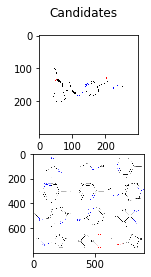

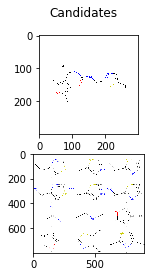

In [34]:
data_iter = iter(dataloader)
batch = next(data_iter)
#for key in batch.keys():
    #print("{}: {}".format(key, batch[key]))
mol_tree = batch['mol_trees'][0]
graph_batch = batch['mol_graph_batch']
line_graph = graph_batch.line_graph(backtracking=False, shared=True)

#mols = [Chem.MolFromSmiles(mg.smiles) for mg in batch]

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
#plt.subplot(121)
#nx.draw(mol_tree.to_networkx(), with_labels=True)
#plt.show()
#plt.subplot(121)
#nx.draw(line_graph.to_networkx(), with_labels=True)
#plt.show()

from rdkit.Chem import Draw
#smile_img = Draw.MolToImage(Chem.MolFromSmiles(batch['smiles'][0]))
#imshow(smile_img)
#Draw.MolsToGridImage(mols[0:6],molsPerRow=3,subImgSize=(300,200),legends=smiles)

%matplotlib inline
for i,img in enumerate(batch['smiles_img']):
    fig, axs = plt.subplots(len(batch['smiles_img']))
    fig.suptitle('Candidates')
    axs[0].imshow(img)
    plt.imsave('mol'+str(i)+'.png', np.array(img))
    axs[1].imshow(batch['img_grid'][i])
    plt.imsave('mol'+str(i)+'cands.png', np.array(batch['img_grid'][i]))

mpn = GraphConvNet(args)

#_ = [next(data_iter) for _ in range(200)]
print(mpn(batch['mol_graph_batch'])[:1,0])
for _ in range(0,100):
    print(mpn(next(data_iter)['mol_graph_batch'])[:1,0])